In [1]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")

# we will impute using surface area as our distance metric
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length

in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]



In [3]:
def load_zeropoint(zpf):
    zeropoint = pd.read_csv(zpf, names=["ts", "avg"], header=0)
    zeropoint["ts"] = pd.to_datetime(zeropoint["ts"])
    zeropoint = zeropoint.sort_values("ts").set_index("ts")
    return zeropoint.resample('10T').mean()

def subtract_zeropoint_plot(night, return_dfs=False):
    zeropoint_d6 = load_zeropoint("weather_results/d6/v2/{}.csv".format(night))
    zeropoint_d9 = load_zeropoint("weather_results/d9/v2/{}.csv".format(night))
    
    try:
        final_light_d6 = pd.read_csv("data/bbl_{}/{}_d6_10m.csv".format(night, night))
        final_light_d9 = pd.read_csv("data/bbl_{}/{}_d9_10m.csv".format(night, night))
    except:
        final_light_d6 = pd.read_csv("data/{}_d6_10m.csv".format(night, night))
        final_light_d9 = pd.read_csv("data/{}_d9_10m.csv".format(night, night))

    for df in (final_light_d6, final_light_d9):
        del df["Unnamed: 0"]
        del df["lat"]
        del df["lng"]
    final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
    final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)
    if return_dfs:
        return final_light_d6, final_light_d9
    intersection = final_light_d6.columns[final_light_d6.columns.isin(final_light_d9.columns)]
    fig, axes = plt.subplots(3, 2, figsize=(16, 15))
    (ax1, ax2, ax3, ax4, ax5, ax6) = axes.flatten()
    samp = np.random.choice(intersection, 10, replace=False)
    final_light_d6[samp].plot(ax=ax1)
    subbed_d6 = final_light_d6.apply(lambda x: x - zeropoint_d6["avg"])
    subbed_d6[samp].plot(ax=ax2)
    final_light_d9[samp].plot(ax=ax3)
    subbed_d9 = final_light_d9.apply(lambda x: x - zeropoint_d9["avg"])
    subbed_d9[samp].plot(ax=ax4)
    zeropoint_d6["avg"].plot(ax=ax5)
    zeropoint_d9["avg"].plot(ax=ax6)
    
    n = (subbed_d6 < 0).sum().sum() 
    d = subbed_d6.count().sum()
    print("d6 : {}/{} == {}".format(n, d, n/d))
    n = (subbed_d9 < 0).sum().sum() 
    d = subbed_d9.count().sum()
    print("d9 : {}/{} == {}".format(n, d, n/d))
    #return zeropoint_d9

#subbed_d6 = subtract_zeropoint_plot("2017-09-28")

In [ ]:
subtract_zeropoint_plot("2017-09-26")

In [ ]:
subtract_zeropoint_plot("2017-09-27")

In [ ]:
subtract_zeropoint_plot("2017-09-29")

In [ ]:
subtract_zeropoint_plot("2017-09-30")

d6 : 3001/138078 == 0.02173409232462811
d9 : 66482/101574 == 0.6545178884360171


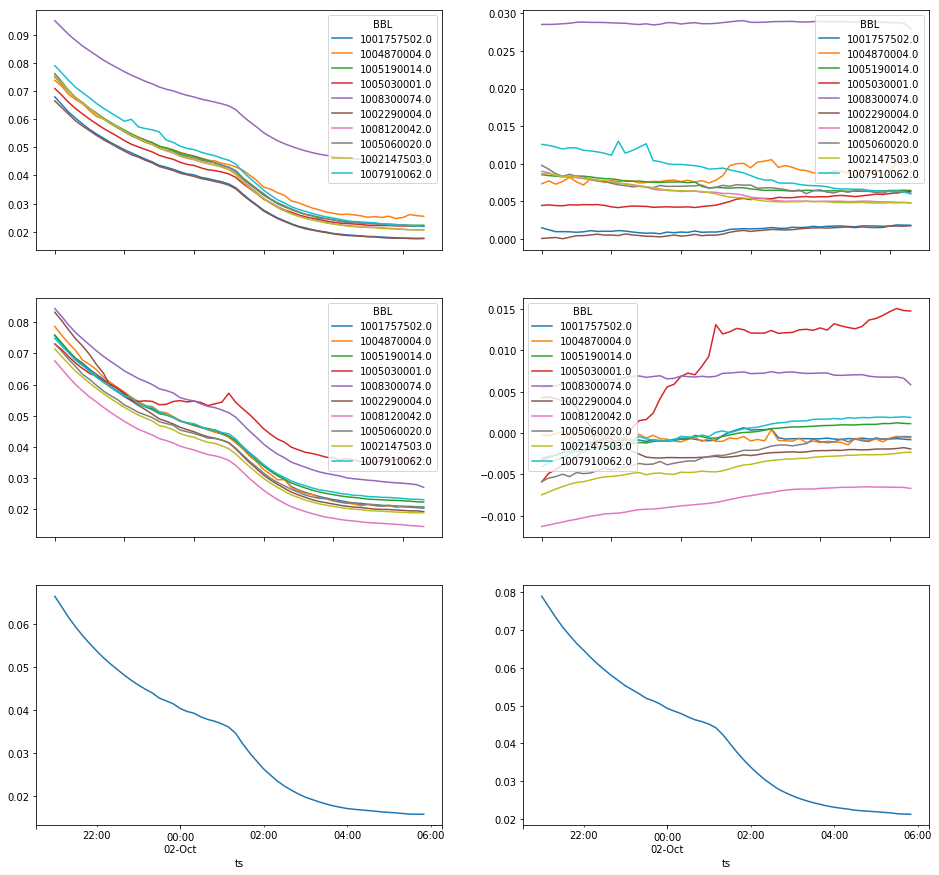

In [4]:
subtract_zeropoint_plot("2017-10-01")

d6 : 753/138078 == 0.005453439360361535
d9 : 61320/101574 == 0.6036977966802528


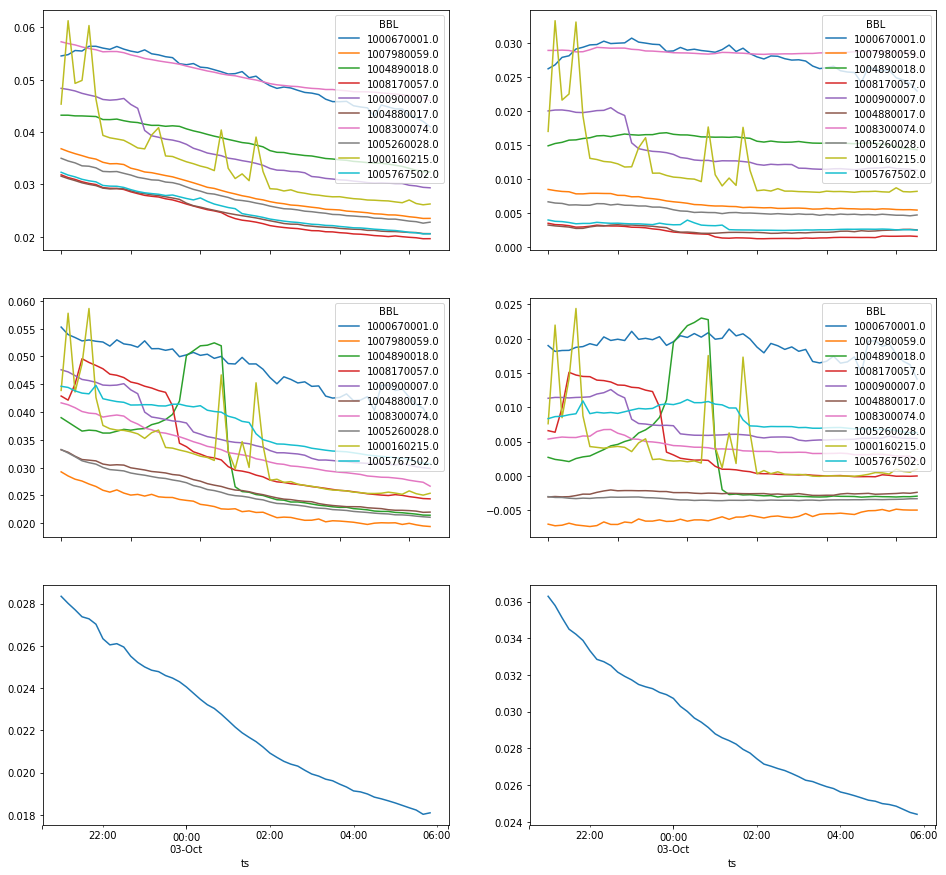

In [5]:
subtract_zeropoint_plot("2017-10-02")

d6 : 321/138078 == 0.0023247729544170685
d9 : 56859/101574 == 0.559779077322937


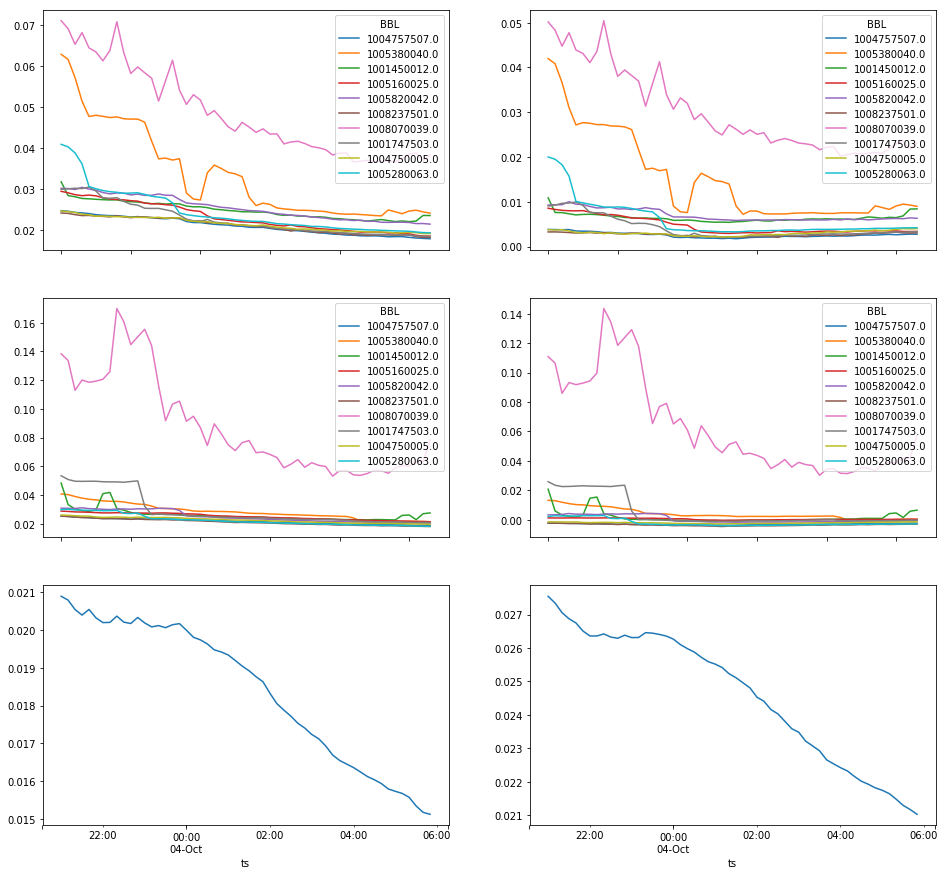

In [6]:
subtract_zeropoint_plot("2017-10-03")

(500,
 1300,
 4000,
 4800,
 (3840, 5120),
 '/uofs15tb_gpfs/data/2017-09-28_night/0_d9_1506646816.png',
 '/uofs15tb_gpfs/data/2017-09-28_night/3148_d9_1506679190.png',
 0.033608723,
 0.020964427)

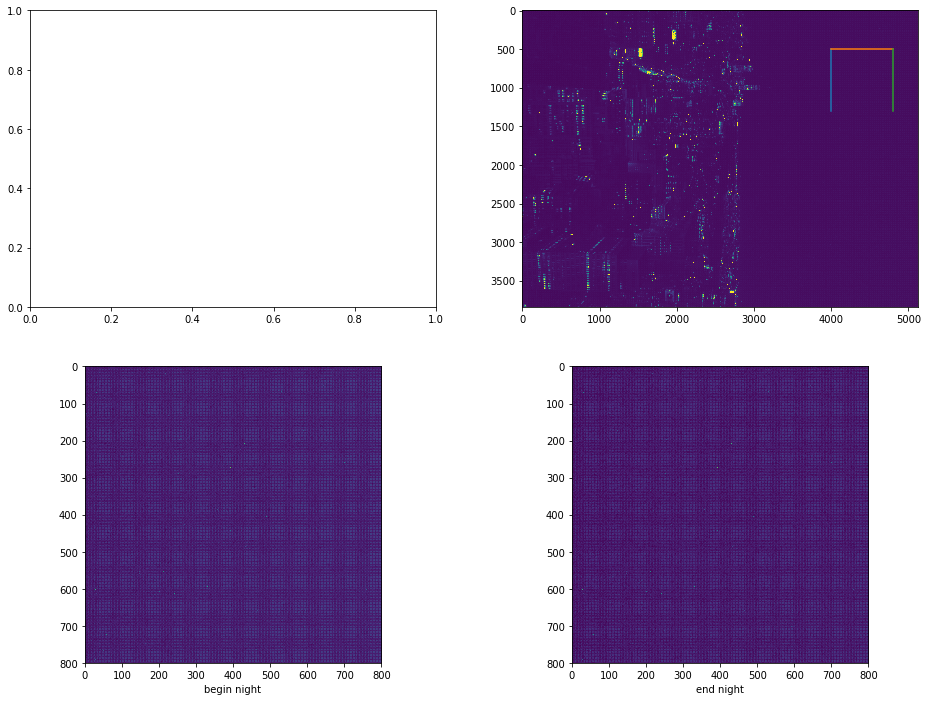

In [7]:
import weather
from importlib import reload
reload(weather)

night="2017-09-28"
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2, ax3, ax4) = axes.flatten()
#zeropoint_d9["avg"].plot(ax=ax1)
ims = weather.images_for_night(night, 'd9')
ax2.imshow(plt.imread(ims[0]))
x1, x2, y1, y2 = weather.d9_skypatch
y1, y2, x1, x2, = weather.d9_skypatch_v2
ax2.plot( [x1, x1], [y1, y2])
ax2.plot( [x1, x2], [y1, y1],)
ax2.plot([x2, x2], [y1, y2])
#ax2.plot([x1, x2], [y2, y2])
ax3.imshow(plt.imread(ims[0])[y1:y2, x1:x2])
ax3.set_xlabel("begin night")
ax4.imshow(plt.imread(ims[-1])[y1:y2, x1:x2])
ax4.set_xlabel("end night")
y1, y2, x1, x2, plt.imread(ims[0]).shape, ims[0], ims[-1], plt.imread(ims[0])[y1:y2, x1:x2].mean(), plt.imread(ims[-1])[y1:y2, x1:x2].mean()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
samp = np.random.choice(final_light_d9.columns, 10, replace=False)
final_light_d9[samp].plot(ax=ax1)
final_light_d9.apply(lambda x: x - zeropoint_d9["avg"])[samp].plot(ax=ax2)

## NN Stuff begins

In [ ]:
# resolution strategy when we have 2 measurements: take the means
final_light_d6, final_light_d9 = subtract_zeropoint_plot("2017-09-28", True)
concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()


In [ ]:
if os.path.exists("data/impute_dists_centroid.gz"):
    dists = joblib.load("data/impute_dists_centroid.gz")
    nearest_idxs = joblib.load("data/impute_idxs_centroid.gz")
else:
    dists = []
    nearest_idxs = []
    for ix, building in out_frame.iterrows():
        if ix % 1000 == 0:
            print("at", ix)
        ds = in_frame.geometry.centroid.distance(building.geometry.centroid)
        dists.append(ds.min())
        nearest_idxs.append(ds.idxmin())
    joblib.dump(dists, "data/impute_dists_centroid.gz", 3)
    joblib.dump(nearest_idxs, "data/impute_idxs_centroid.gz", 3)
    
dists_arr = np.array(dists)

out_reset = out_frame.reset_index()
out_reset["dist"] = dists_arr


In [ ]:
nearest_neighbors = [np.abs(in_frame.surface_area - osa).sort_values()[:10].index\
                     for osa in out_frame.surface_area]
out_reset["nearest_ix"] = nearest_neighbors

nearest_neighbors_100 = [np.abs(in_frame.surface_area - osa).sort_values()[:100].index\
                     for osa in out_frame.surface_area]
out_reset["nearest_ix_100"] = nearest_neighbors_100

In [ ]:
medians = []
for i, indices in enumerate(out_reset["nearest_ix"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    medians.append((i, median))
medians = np.array(medians, dtype=[('ix', int), ('median', np.float64)])

medians_100 = []
for i, indices in enumerate(out_reset["nearest_ix_100"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    medians_100.append((i, median))
medians_100 = np.array(medians_100, dtype=[('ix', int), ('median', np.float64)])


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.hist(medians['median'])
ax2.hist(np.log(medians['median']))

In [ ]:
medians_sorted = np.sort(medians, order='median')
medians_100_sorted = np.sort(medians_100, order='median')

In [ ]:
colors = ['red'] * 4 + ['orange'] * 4 + ['yellow'] * 4 + ['green'] * 4
indices = [medians_sorted[int(len(medians) * (i / 16))] for i in range(15)] + [medians_sorted[-1]]
# 0 / 16 .. 14/16
indices_100 = [medians_100_sorted[int(len(medians) * (i / 16))] for i in range(15)] + [medians_100_sorted[-1]]


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2, ax3, ax4) = axes.flatten()
ax1.hist(medians['median'])
for i, ix in enumerate(indices):
    ax1.axvline(ix[1], linestyle='dashed', color=colors[i])
ax1.set_xlabel("10nn, with 10nn indices")

ax2.hist(medians_100['median'])
for i, ix in enumerate(indices):
    ixs = out_reset.loc[ix[0]].nearest_ix_100
    cbbl = in_frame.loc[ixs].BBL
    med = final_light[cbbl].mean().median()
    ax2.axvline(med, linestyle='dashed', color=colors[i])
ax2.set_xlabel("100nn, with 10nn indices")
ax2.set_xlim(ax1.get_xlim())

ax3.hist(medians['median'])
for i, ix in enumerate(indices_100):
    ixs = out_reset.loc[ix[0]].nearest_ix
    cbbl = in_frame.loc[ixs].BBL
    med = final_light[cbbl].mean().median()
    ax3.axvline(med, linestyle='dashed', color=colors[i])
ax3.set_xlabel("10nn, with 100nn indices")


ax4.hist(medians_100['median'])
for i, ix in enumerate(indices_100):
    ixs = out_reset.loc[ix[0]].nearest_ix_100
    cbbl = in_frame.loc[ixs].BBL
    med = final_light[cbbl].mean().median()
    ax4.axvline(med, linestyle='dashed', color=colors[i])
ax4.set_xlabel("100nn, with 100nn indices")
ax4.set_xlim(ax1.get_xlim())


In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices]]["nearest_ix"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 11), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices]]["nearest_ix_100"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 101), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])

In [ ]:
frac = int(10 * len(medians) / 11)
lmedians =  medians_sorted[:frac]
umedians = medians_sorted[frac:]

indices_2 = [lmedians[int(len(lmedians) * (i / 8))] for i in range(7)] +\
            [umedians[int(len(umedians) * (i / 8))] for i in range(7)] +\
            [umedians[-30], umedians[-1]]
fig, ax = plt.subplots()
ax.hist(medians['median'])
for i, ix in enumerate(indices_2):
    ax.axvline(ix[1], linestyle='dashed', color=colors[i])
len(indices_2)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices_2]]["nearest_ix"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 11), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices_2]]["nearest_ix_100"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 101), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])



In [ ]:
fig, ax = plt.subplots( figsize=(16, 9))

sa_diffs = out_reset.apply(lambda x: np.abs(x["surface_area"] - in_frame.loc[x["nearest_ix"][0]].surface_area), axis=1)
brightnesses = out_reset.apply(lambda x: final_light[in_frame.loc[x["nearest_ix"][0]].BBL].mean(), axis=1)

ax.scatter(np.log(sa_diffs), brightnesses)
ax.set_title("mean brightness of nearest neighbor vs. log difference in surface area", fontsize=16)

In [ ]:
x = out_reset.loc[sa_diffs.argmax()]
in_frame.loc[x["nearest_ix"][0]].surface_area, x.surface_area, np.log(np.abs(in_frame.loc[x["nearest_ix"][0]].surface_area - x.surface_area))
in_frame.loc[x["nearest_ix"][0]].surface_area
in_frame.loc[x["nearest_ix"][0]]
10**5

### Now, residential vs. commercial

In [ ]:
import string
RESIDENTIAL = set("ABCDHLNRS")
COMMERCIAL = set(string.ascii_uppercase) - RESIDENTIAL
print(" residential: ", RESIDENTIAL,"\n", "commercial: ", COMMERCIAL)

ind = in_frame.dropna(subset=["BldgClass"])
in_residential = ind[ind.BldgClass.str[0].isin(RESIDENTIAL)]
in_commercial = in_frame[~in_frame.index.isin(in_residential.index)]
print(" residential: ", len(in_residential))
print(" commercial: ", len(in_commercial))
print(" ratio:", len(in_residential) / len(in_frame))
print(" total: ", len(in_frame))

In [ ]:
nearest_neighbors = []
res_count = 0
for ix, of in out_frame.iterrows():
    osa = of.surface_area
    if (of.BldgClass and of.BldgClass[0] in RESIDENTIAL):
        areas = in_residential 
        res_count += 1
    else:
        areas = in_commercial
    nearest_neighbors.append(np.abs(areas.surface_area - osa).sort_values()[:10].index)
    

out_reset["nearest_ix_residential"] = nearest_neighbors
res_count, len(out_frame), res_count / len(out_frame)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
vals = []
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix].BBL
    c_all = final_light[list(cbbl)].mean().mean()
    cbbl_res = in_frame.loc[o_r.nearest_ix_residential].BBL
    c_res = final_light[list(cbbl_res)].mean().mean()
    
    polys.append(PolygonPatch(o_r.geometry))
    val = (np.abs(c_all - c_res))
    vals.append(val)

scale = (max(vals) - min(vals))
for val in vals:
    colors.append(plt.cm.gist_heat(val / scale))
    
# for _, i_r in in_frame.iterrows():
#     c = final_light[i_r.BBL].mean()
#     polys.append(PolygonPatch(i_r.geometry))
#     colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)
ax.set_title("difference of (residential vs. commercial nearest neighbors) - (all nearest neighbors)")
min(vals), max(vals)

In [ ]:
fig, ax = plt.subplots( figsize=(16, 9))

sa_diffs = out_reset.apply(lambda x: np.abs(x["surface_area"] - in_frame.loc[x["nearest_ix_residential"][0]].surface_area), axis=1)
brightnesses = out_reset.apply(lambda x: final_light[in_frame.loc[x["nearest_ix_residential"][0]].BBL].mean(), axis=1)

ax.scatter(np.log(sa_diffs), brightnesses, c=out_reset.BldgClass.str[0].isin(RESIDENTIAL))
ax.set_title("mean brightness of nearest neighbor vs. log difference in surface area, res/com split", fontsize=16)

In [ ]:
fig, ax = plt.subplots( figsize=(16, 9))

sas = out_reset["surface_area"]
ax.scatter(np.log(sas), brightnesses, c=out_reset.BldgClass.str[0].isin(RESIDENTIAL))
ax.set_title("mean brightness of nearest neighbor vs. surface area of out-of-frame building, res/com split", fontsize=16)

In [ ]:
fig, ax = plt.subplots( figsize=(16, 9))

sas = in_frame["surface_area"]
ax.scatter(np.log(sas), , c=out_reset.BldgClass.str[0].isin(RESIDENTIAL))
ax.set_title("mean brightness of nearest neighbor vs. surface area of out-of-frame building, res/com split", fontsize=16)